# Models


# Model 2 with kmeans

- get_dummies categorical data.
- perform feature selection.
- perform k-means

## Import libraries/packages

In [43]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
# from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

##################################

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Metrics ###
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [44]:
# Load the data.
file = 'car.csv'
data = pd.read_csv(file)

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   buying     1728 non-null   object
 1   maint      1728 non-null   object
 2   doors      1728 non-null   object
 3   persons    1728 non-null   object
 4   lug_boot   1728 non-null   object
 5   safety     1728 non-null   object
 6   class_val  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [45]:
# Shape of the data set.
print("The data set has {} rows and {} columns.".format(
    data.shape[0], data.shape[1]))

The data set has 1728 rows and 7 columns.


In [46]:
# Check for missing values.
data.isna().any()

buying       False
maint        False
doors        False
persons      False
lug_boot     False
safety       False
class_val    False
dtype: bool

In [47]:
# Check for duplicate rows.
data.duplicated().any()

False

In [48]:
# Checking the values from each column.
for col in data.columns:
    print("Column:", col)
    print(data[col].value_counts(), '\n')

Column: buying
med      432
high     432
vhigh    432
low      432
Name: buying, dtype: int64 

Column: maint
med      432
high     432
vhigh    432
low      432
Name: maint, dtype: int64 

Column: doors
2        432
5more    432
3        432
4        432
Name: doors, dtype: int64 

Column: persons
2       576
more    576
4       576
Name: persons, dtype: int64 

Column: lug_boot
big      576
med      576
small    576
Name: lug_boot, dtype: int64 

Column: safety
med     576
high    576
low     576
Name: safety, dtype: int64 

Column: class_val
unacc    1210
acc       384
good       69
vgood      65
Name: class_val, dtype: int64 



In [49]:
# Plotting the values of each column.
for i in data.columns:
    labels = data[i].unique()
    values = data[i].value_counts()
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(title=go.layout.Title(
        text='Value distribution for column: "{}"'.format(i), x=.5))
    fig.show()

Since all the columns are categorical, we change the data types to "category". This will come in handy in case we want to sort any column of the data set.

## Part 2: Preprocessing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [50]:
# The data set after the conversion.
data.head()

,buying,maint,doors,persons,lug_boot,safety,class_val
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [51]:
# Choose attribute columns and class column.
X = data[data.columns[:-1]]
y = data['class_val']

In [52]:
# OneHot encoder for all the features.
X = pd.get_dummies(X)

# Label encoder for 'class_val'
y = y.replace({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

In [53]:
len(X.columns)

21

## Feature selection

In [54]:
from sklearn.feature_selection import SelectKBest

In [55]:
def find_best_k(X, y, tol=0.001, n_iter_no_change=10, n_clusters=2, verbose=False):
    from sklearn.feature_selection import SelectKBest
    scores = []
    n_features = len(X.columns)
    no_improvement_counter = 0
    best_validation_score_ = -np.inf

 # Main loop
    for kappa in range(1, n_features+1):
        X_new = SelectKBest(k=kappa).fit_transform(X, y)
        sc = StandardScaler()
        sc.fit(X_new)
        X_new = sc.transform(X_new)
        X_new = pd.DataFrame(X_new)
        model = KMeans(n_clusters=2, random_state=25).fit(X_new)
        X_new['cluster'] = model.labels_
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y, test_size=0.3, random_state=25)
        smt = SMOTE(k_neighbors=6,random_state=0)
        X_train, y_train = smt.fit_sample(X_train, y_train)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    # Initialize a Logistic Regression estimator.
        logreg = LogisticRegression(
            multi_class='auto', random_state=25, n_jobs=-1)
    # Train the estimator.
        logreg.fit(X_train, y_train)
        kappa_score = logreg.score(X_test,y_test)
        scores.append(kappa_score)
        last_valid_score = scores[-1]

        if verbose:
            print(
                f'K={kappa}, No improvement for {no_improvement_counter} rounds, Best score: {best_validation_score_}')

        if last_valid_score < (best_validation_score_ + tol):
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if no_improvement_counter > n_iter_no_change:
            break

        if last_valid_score > best_validation_score_:
            best_validation_score_ = last_valid_score

    fig, ax = plt.subplots()
    ax.plot([k for k in range(1,len(scores)+1)],
            scores, marker='o', label="Scores")
    ax.axvline(x=scores.index(best_validation_score_)+1, ymin=0, ymax=1, color='r', ls='--',
               label=f'Best score\nfor K={scores.index(best_validation_score_)+1}')
    plt.legend()
    plt.title(
        f'Scores of classification with K-means')

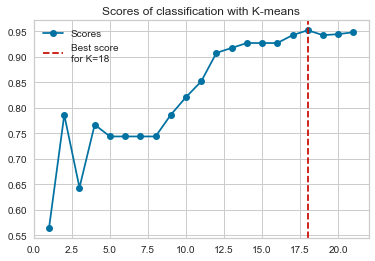

In [56]:
find_best_k(X, y, n_clusters=4, tol=0.001)

In [92]:
# Best k for CV accuracy: 18

In [57]:
X = SelectKBest(k=18).fit_transform(X, y)

## Kmeans analysis

In [58]:
# Create a k-means model with k=4.
model = KMeans(n_clusters=4, random_state=25)

In [59]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X = pd.DataFrame(X)

In [60]:
X['cluster'] = model.fit_predict(X)

In [61]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [62]:
smt = SMOTE(k_neighbors=6,random_state=0)
X_train, y_train = smt.fit_sample(X_train, y_train)

In [63]:
# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network



In [64]:
scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro','roc_auc_ovr']

## Logistic Regression

In [65]:
# Initialize a Logistic Regression classifier.
logreg = LogisticRegression(
    solver='saga', multi_class='auto', random_state=42, n_jobs=-1)

# Train the classifier.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [66]:
# Make predictions.
log_pred = logreg.predict(X_test)

# CV score
logreg_cv = cross_validate(logreg, X, y, cv=10,scoring=scoring, n_jobs=-1)

In [67]:
logreg_cv.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_roc_auc_ovr'])

## Metrics for Logistic Regression

In [68]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))


# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred, average='macro'))

Accuracy: 0.928
Precision: 0.795
Recall: 0.916
F1 score: 0.844


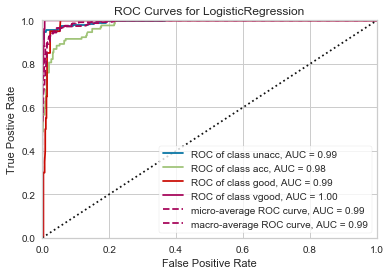

In [69]:
from yellowbrick.classifier import ROCAUC


model = logreg
visualizer = ROCAUC(model, classes=['unacc', 'acc', 'good', 'vgood'])

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [70]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % logreg_cv['test_accuracy'].mean())

# Precision
print('cv_Precision: %.3f' % logreg_cv['test_precision_macro'].mean())

# Recall
print('cv Recall: %.3f' % logreg_cv['test_recall_macro'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % logreg_cv['test_f1_macro'].mean())

print('cv AUC score: %.3f' % logreg_cv['test_roc_auc_ovr'].mean())

Accuracy: 0.928
Cross-validation accuracy: 0.844
cv_Precision: 0.771
cv Recall: 0.740
cv F1 score: 0.714
cv AUC score: 0.977


## Confusion Matrix for Logistic Regression

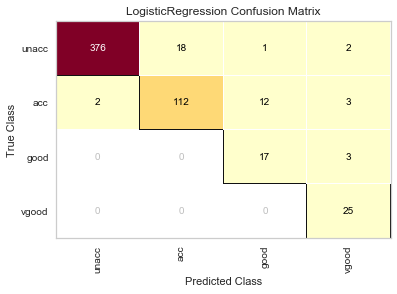

In [71]:
cm = ConfusionMatrix(logreg, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Decision tree

In [72]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(
    max_depth=30, criterion='gini', random_state=42)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Text(0.5, 1.0, 'Decision Tree')

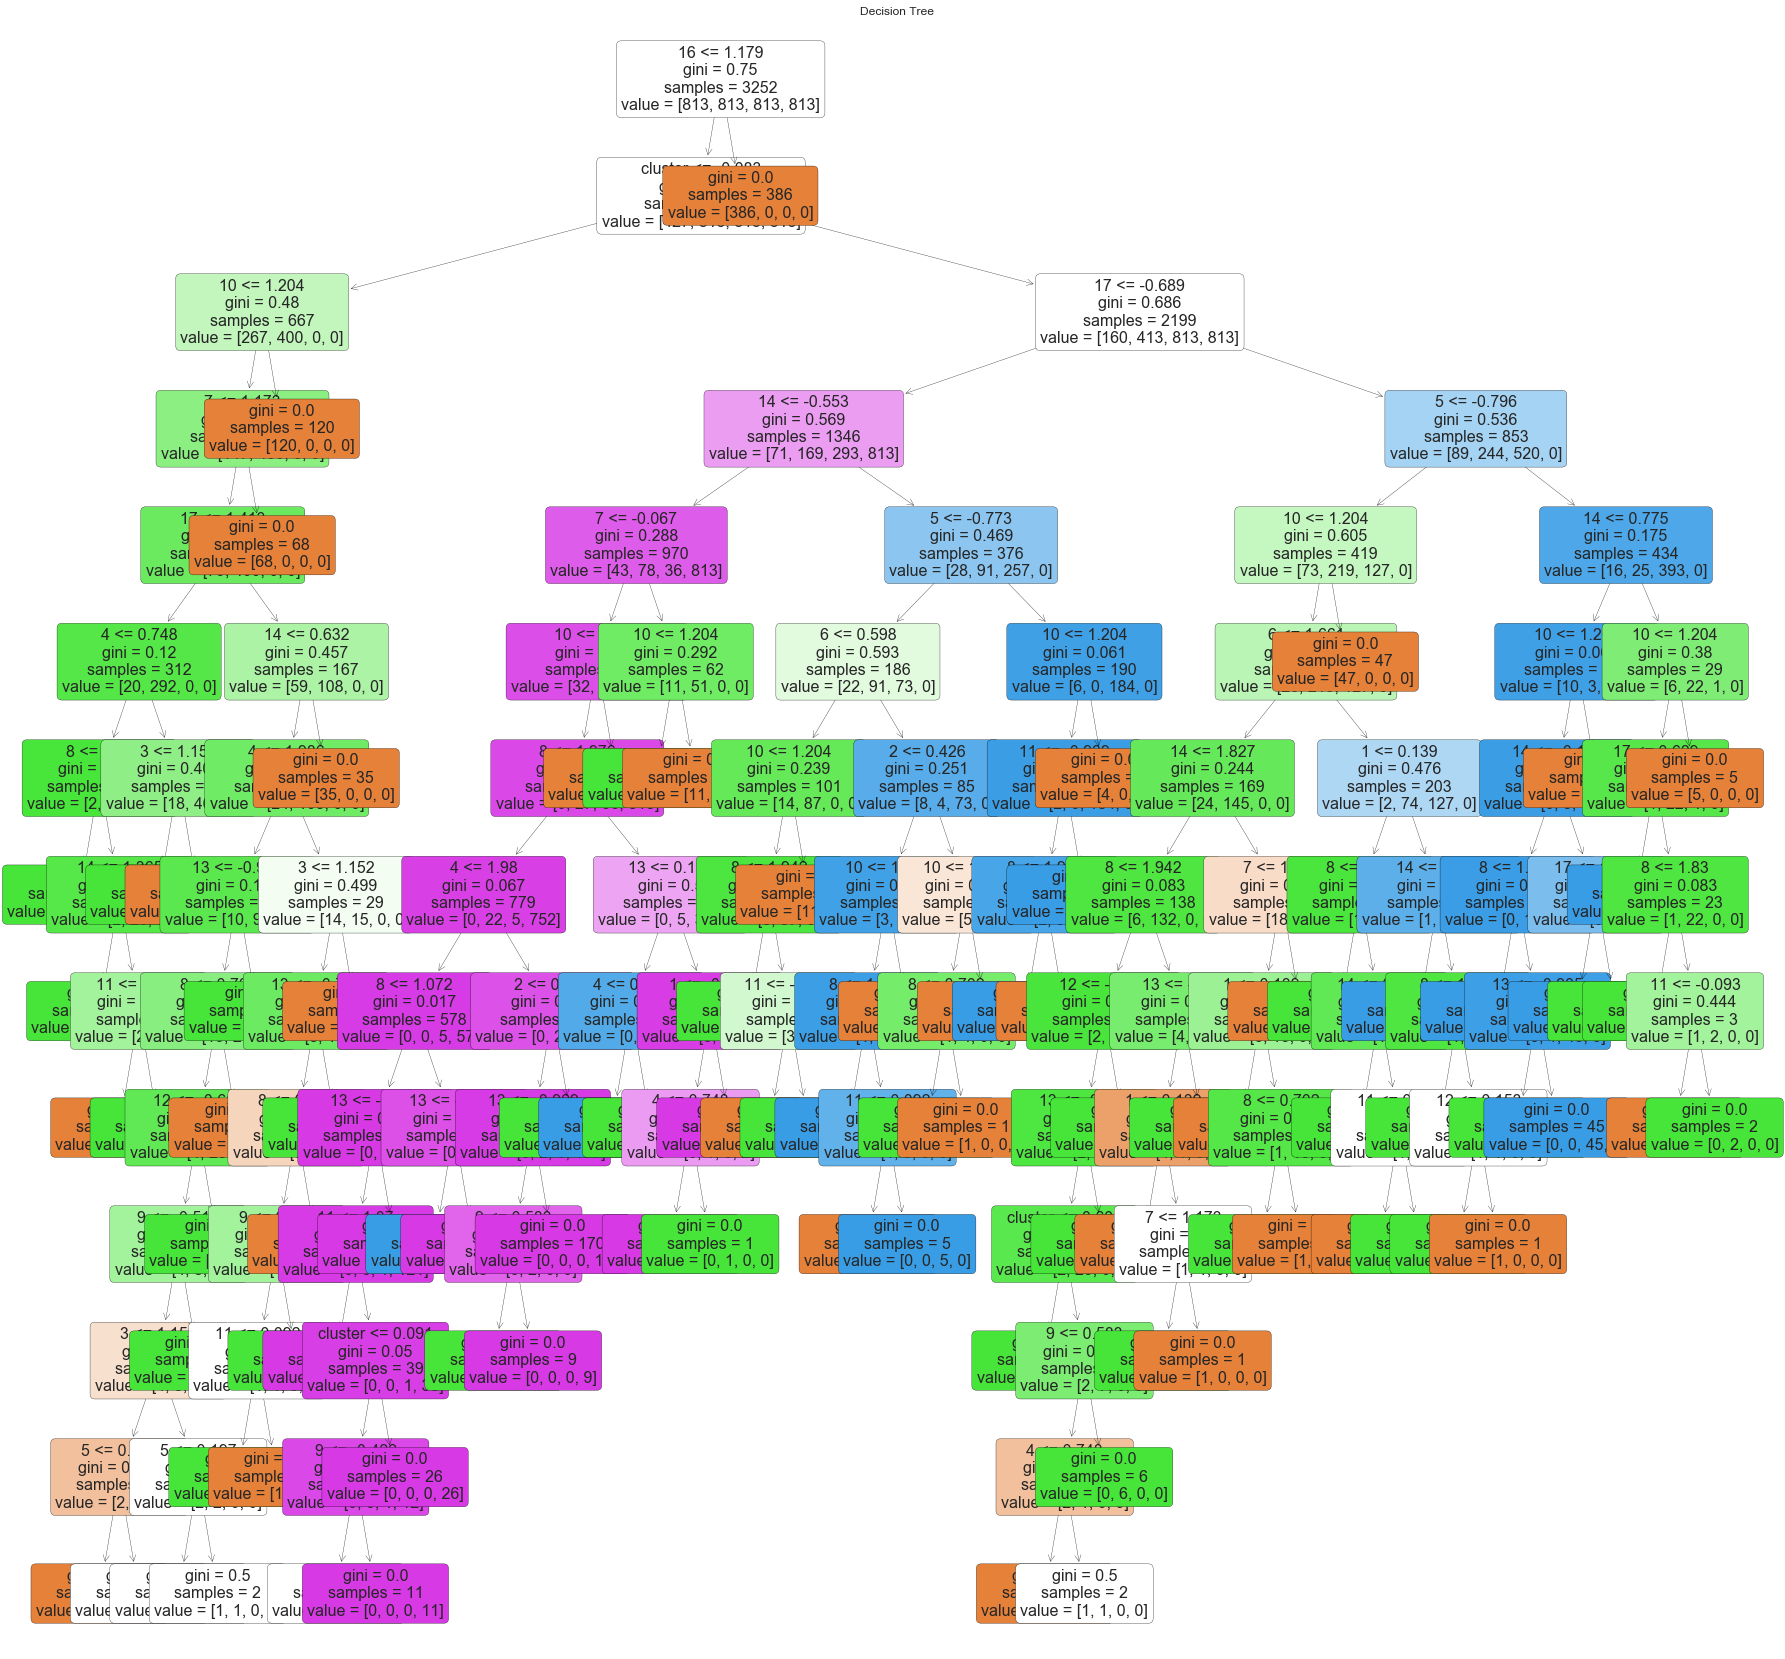

In [73]:
# Plot the tree.
fig = plt.figure(figsize=(30, 30))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [74]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

NameError: name 'export_text' is not defined

In [75]:
# Make predictions.
tr_pred = tr.predict(X_test)

# CV score
tr_cv = cross_validate(tr, X, y, cv=10,scoring=scoring, n_jobs=-1)

## Metrics for Decision tree

In [76]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % tr_cv['test_accuracy'].mean())

# Precision
print('cv_Precision: %.3f' % tr_cv['test_precision_macro'].mean())

# Recall
print('cv Recall: %.3f' % tr_cv['test_recall_macro'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % tr_cv['test_f1_macro'].mean())

print('cv AUC score: %.3f' % tr_cv['test_roc_auc_ovr'].mean())

Accuracy: 0.965
Cross-validation accuracy: 0.876
cv_Precision: 0.847
cv Recall: 0.828
cv F1 score: 0.819
cv AUC score: 0.889


In [77]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))


# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, tr_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred, average='macro'))

Accuracy: 0.965
Precision: 0.891
Recall: 0.921
F1 score: 0.901


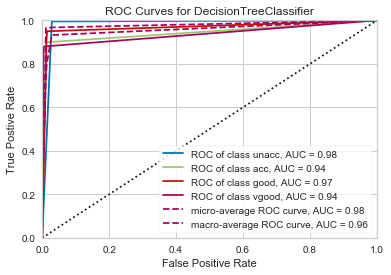

In [78]:
from yellowbrick.classifier import ROCAUC


model = tr
visualizer = ROCAUC(model, classes=['unacc', 'acc', 'good', 'vgood'])

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

## Confusion Matrix for Decision tree

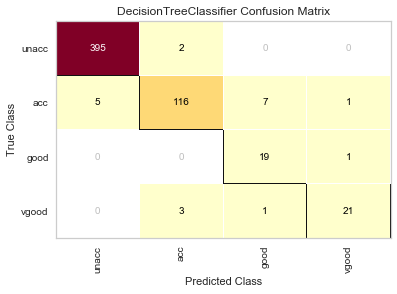

In [79]:
# Print confusion matrix for Decision tree.
cm = ConfusionMatrix(tr, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Neural network (MLP)

In [80]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=1000,
                    random_state=42, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 5), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [81]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score
mlp_cv = cross_validate(mlp, X, y, cv=10, scoring=scoring, n_jobs=-1)

## Metrics for Neural Network (MLP)

In [82]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % mlp_cv['test_accuracy'].mean())

# Precision
print('cv_Precision: %.3f' % mlp_cv['test_precision_macro'].mean())

# Recall
print('cv Recall: %.3f' % mlp_cv['test_recall_macro'].mean())

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('cv F1 score: %.3f' % mlp_cv['test_f1_macro'].mean())

print('cv AUC score: %.3f' % mlp_cv['test_roc_auc_ovr'].mean())

Accuracy: 0.928
Cross-validation accuracy: 0.873
cv_Precision: 0.816
cv Recall: 0.834
cv F1 score: 0.797
cv AUC score: 0.966


In [83]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))


# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred, average='macro'))

Accuracy: 0.961
Precision: 0.872
Recall: 0.935
F1 score: 0.899


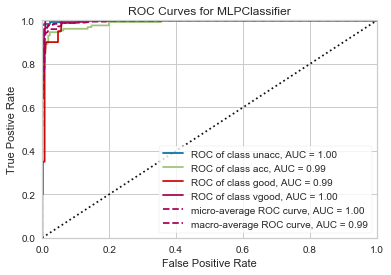

In [84]:
from yellowbrick.classifier import ROCAUC


model = mlp
visualizer = ROCAUC(model, classes=['unacc', 'acc', 'good', 'vgood'])

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

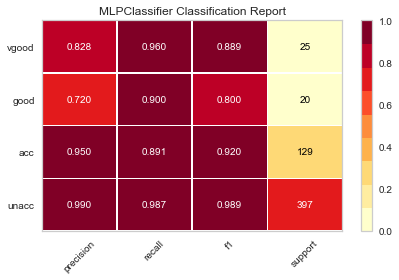

In [85]:
from yellowbrick.classifier import ClassificationReport

# Specify the target classes
classes = ['unacc', 'acc', 'good', 'vgood']


model = mlp
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                  

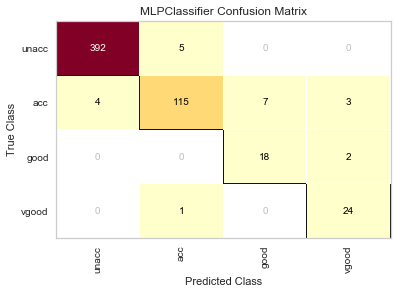

In [86]:
# Plot confusion matrix for MLP.
cm = ConfusionMatrix(mlp, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Results

In [87]:
metrics = ['Accuracy', 'CV accuracy', 'Precision', 'Recall', 'F1', 'AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test), logreg_cv.mean(), precision_score(y_test, log_pred, average='macro'), recall_score(y_test, log_pred, average='macro'), f1_score(y_test, log_pred, average='macro')]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test), tr_cv.mean(), precision_score(y_test, tr_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), f1_score(y_test, tr_pred, average='macro')]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test), mlp_cv.mean(), precision_score(y_test, mlp_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]),
])

fig.update_layout(title_text='Metrics for all models',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

AttributeError: 'dict' object has no attribute 'mean'

In [88]:
d = {
    'Models': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [logreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)],
    'CV Accuracy': [logreg_cv.mean(), tr_cv.mean(), mlp_cv.mean()],
    'Precision': [precision_score(y_test, log_pred, average='macro'), precision_score(y_test, tr_pred, average='macro'), precision_score(y_test, mlp_pred, average='macro')],
    'Recall': [recall_score(y_test, log_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro')],
    'F1': [f1_score(y_test, log_pred, average='macro'), f1_score(y_test, tr_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]
}

results = pd.DataFrame(data=d).round(3).set_index('Models')
results

AttributeError: 'dict' object has no attribute 'mean'

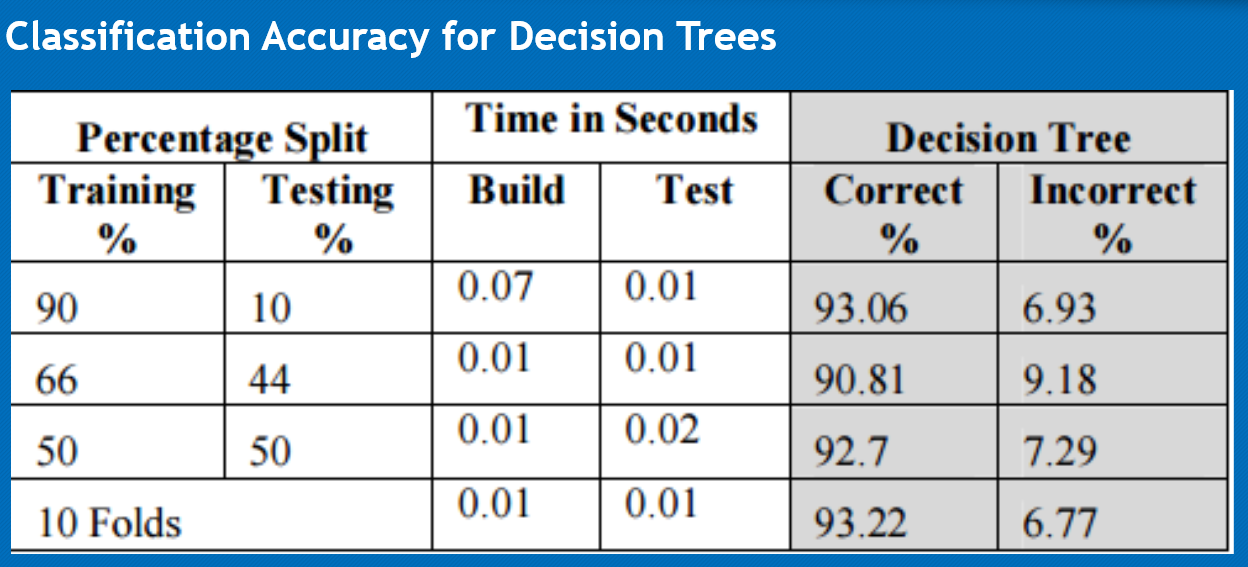

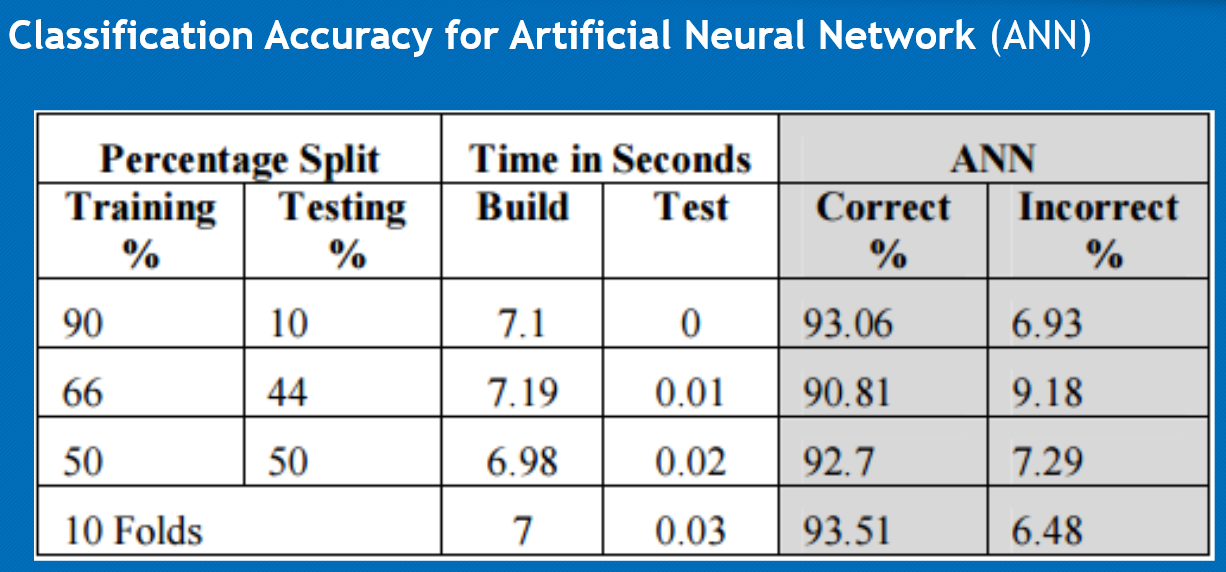

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Error rate $E_{1}$ for model $M_{1}$ on test set $A$.
- Error rate $E_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|E_{1}-E_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.

In [89]:
from itertools import combinations

# Dictionary with all the classifiers.
models = {'LogisticRegression': logreg,
          'DecisionTreeClassifier': tr,
          'MLPClassifier': mlp
          }

def evaluating_performance2(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            E1 = models[model[0]].score(X_test, y_test)
            E2 = models[model[1]].score(X_test, y_test)
            var1 = E1*(1-E1)
            var2 = E2*(1-E2)
            n = len(X_test)
            P = abs(E1-E2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'==>The models {model[0]} and {model[1]} are significant different<==\n')

evaluating_performance2(models)

Comparing Performance between LogisticRegression and DecisionTreeClassifier: 2.773
==>The models LogisticRegression and DecisionTreeClassifier are significant different<==

Comparing Performance between LogisticRegression and MLPClassifier: 2.469
==>The models LogisticRegression and MLPClassifier are significant different<==

Comparing Performance between DecisionTreeClassifier and MLPClassifier: 0.314
There is no significant diferrence between DecisionTreeClassifier and MLPClassifier



|        Models        | Logistic Regression | Decision Tree | Neural Network (MLP) |
|:--------------------:|:-------------------:|:-------------:|:--------------------:|
| Logistic Regression  |          -          |      2.1      |         2.555        |
| Decision Tree        |         2.1         |       -       |         0.149        |
| Neural Network (MLP) |        2.555         |     0.149     |           -          |